<a href="https://colab.research.google.com/github/madedara/kubernetes/blob/master/MaskRCNN-custom-CAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 956 (delta 92), reused 90 (delta 90), pack-reused 863
Receiving objects: 100% (956/956), 125.23 MiB | 29.42 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [ ]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow-gpu==1.15.0
!pip3 install h5py==2.10.0
%tensorflow_version 1.x.

In [ ]:
!pip install -r /content/Mask_RCNN/requirements.txt

In [ ]:
%%shell
cd /content/Mask_RCNN
python /content/Mask_RCNN/setup.py clean --all install

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Import essential libraries

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import time
import skimage
import matplotlib.pyplot as plta
import matplotlib.patches
import xml.etree
import xml.etree.ElementTree
from numpy import zeros, asarray
from PIL import Image, ImageDraw

# ignore warnings to make outputs clearer
import warnings
warnings.filterwarnings('ignore')

# Import maskRCNN

In [ ]:
ROOT_DIR = '/content/Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist.'

# Import mrcnn libraries
sys.path.append(ROOT_DIR)
import mrcnn
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib



# Make a directory to save trained weights
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# path to COCO-dataset weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [ ]:
class CatDataset(utils.Dataset):

	def load_cat(self, dataset_dir, is_train=True):
		self.add_class("dataset", 1, "cat")

		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotation/'

		for filename in os.listdir(images_dir):
			image_id = filename[:-4]

			# if image_id in ['00090']:
			# 	continue

			# if is_train and int(image_id) >= 150:
			# 	continue

			# if not is_train and int(image_id) < 150:
			# 	continue

			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'

			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	def extract_boxes(self, filename):
		tree = xml.etree.ElementTree.parse(filename)

		root = tree.getroot()

		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)

		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')

		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('cat'))
		return masks, asarray(class_ids, dtype='int32')



# Config for custom dataset

In [ ]:
class CatConfig(mrcnn.config.Config):
    NAME = "CatConfig"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 2

    STEPS_PER_EPOCH = 131


In [ ]:
config = CatConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir='./')

weights_path = "/content/Mask_RCNN/mask_rcnn_coco.h5"
# Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
"""Train the model."""
# Training dataset.
train_set = CatDataset()
train_set.load_cat(dataset_dir='/content/gdrive/MyDrive/Colab Notebooks/dataset/train', is_train=True)
train_set.prepare()
# Validation dataset
valid_dataset = CatDataset()
valid_dataset.load_cat(dataset_dir='/content/gdrive/MyDrive/Colab Notebooks/dataset/validation', is_train=False)
valid_dataset.prepare()


In [ ]:
print("Training network heads")
model.train(train_set, valid_dataset,
            learning_rate=config.LEARNING_RATE,
            epochs=3,
            layers='heads')

In [ ]:
class InferenceConfig(CatConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85


inference_config = InferenceConfig()

In [ ]:
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = '/content/gdrive/MyDrive/Colab Notebooks/mask_rcnn_catconfig_0001.h5'
# model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "/content/gdrive/MyDrive/Colab Notebooks/mask_rcnn_catconfig_0001.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


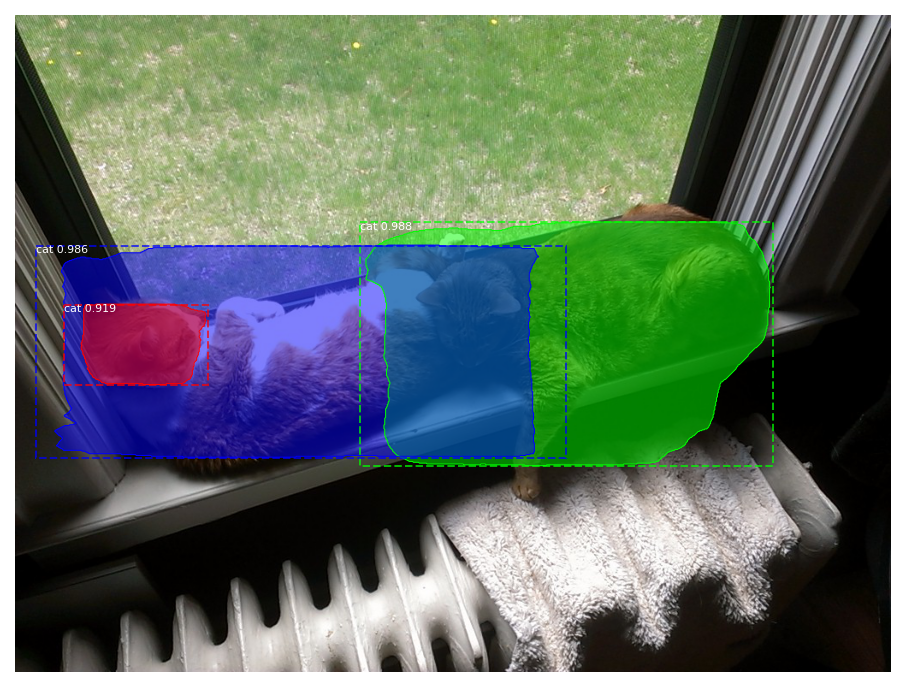

Processing 1 images
image                    shape: (683, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


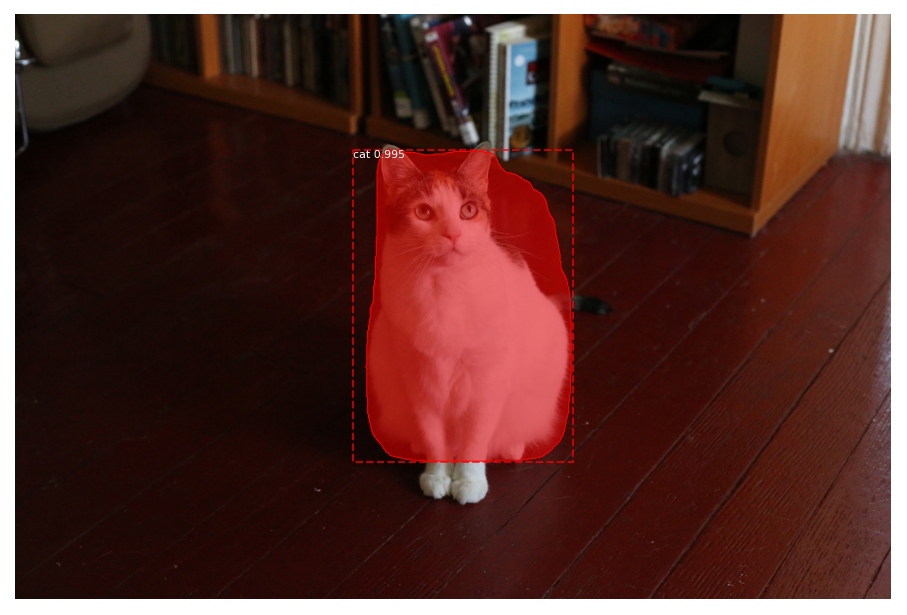

Processing 1 images
image                    shape: (890, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


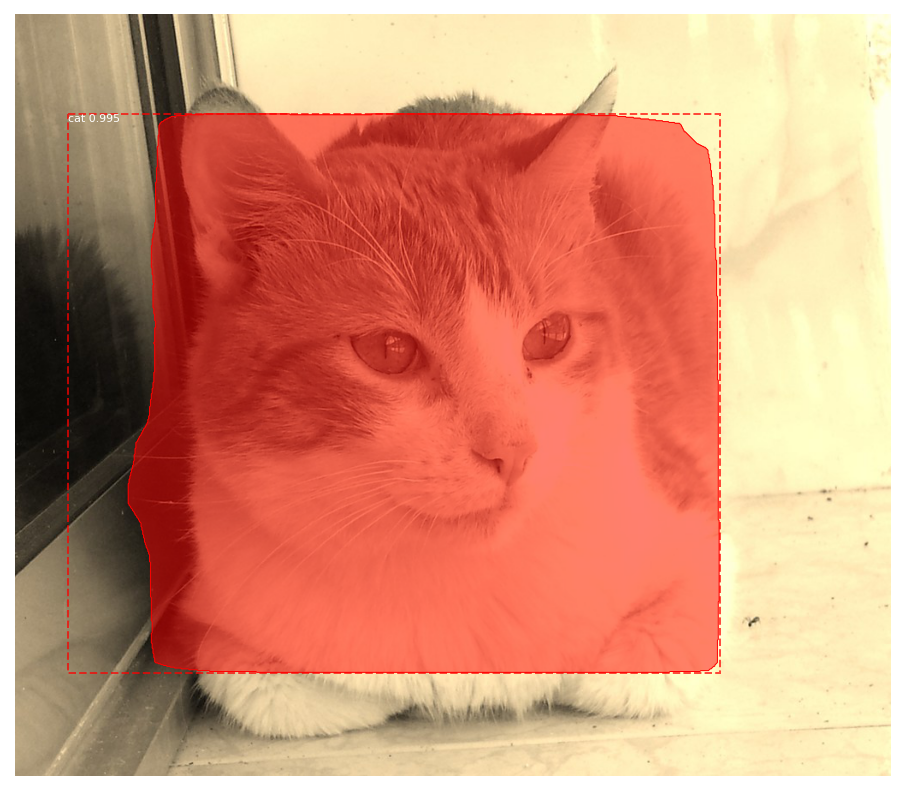

Processing 1 images
image                    shape: (1024, 743, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


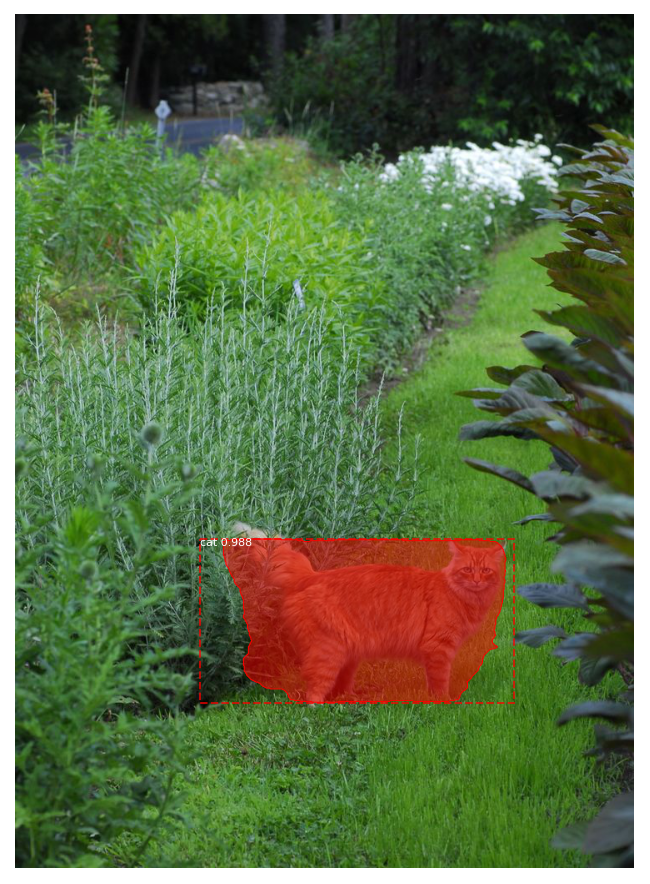

Processing 1 images
image                    shape: (524, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


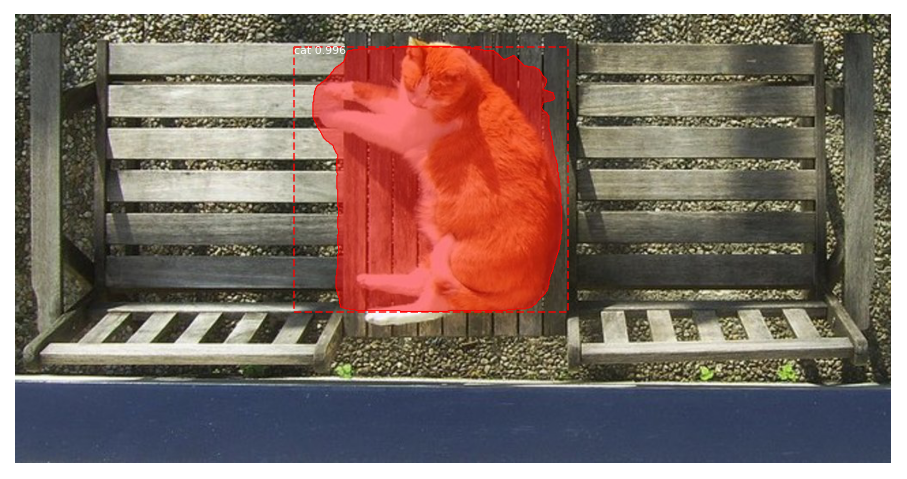

Processing 1 images
image                    shape: (698, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


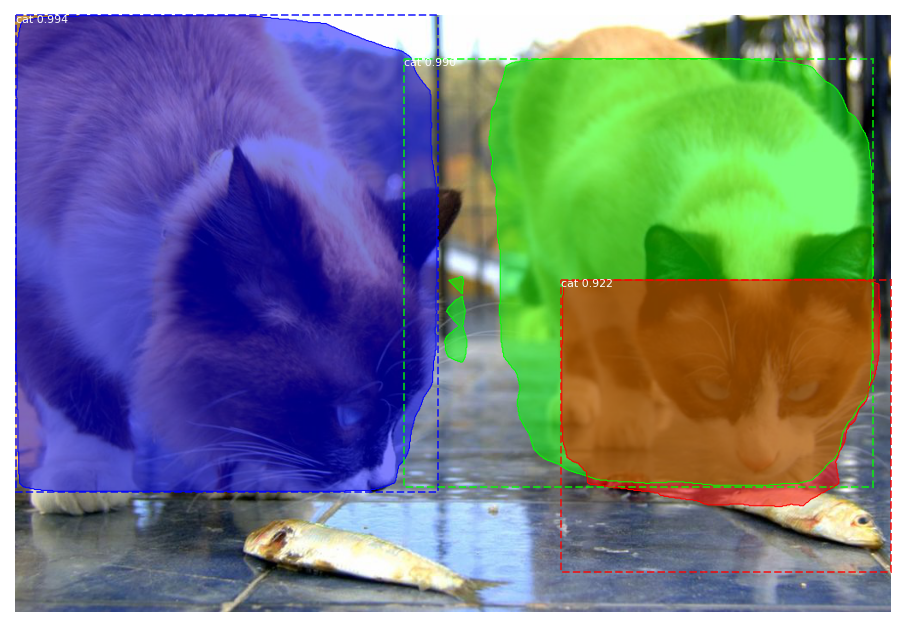

In [ ]:
real_test_dir = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Test/images'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                valid_dataset.class_names, r['scores'], figsize=(16,16))